<a href="https://colab.research.google.com/github/palVikram/Advance_tensorflow/blob/main/Multi_layer_neural_network_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 

<RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [23]:

dataset=tf.data.Dataset.range(10)
dataset=dataset.window(5, shift=1, drop_remainder=True)
dataset=dataset.flat_map(lambda window: window.batch(5))
dataset=dataset.map(lambda window: (window[:-1], window[-1:]))
dataset=dataset.shuffle(buffer_size=10)
dataset=dataset.batch(2).prefetch(1)

In [24]:
for x,y in dataset:
  print("x=", x.numpy())
  print("y=", y.numpy())

x= [[2 3 4 5]
 [1 2 3 4]]
y= [[6]
 [5]]
x= [[4 5 6 7]
 [5 6 7 8]]
y= [[8]
 [9]]
x= [[0 1 2 3]
 [3 4 5 6]]
y= [[4]
 [7]]


In [29]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [30]:
import numpy as np
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [31]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

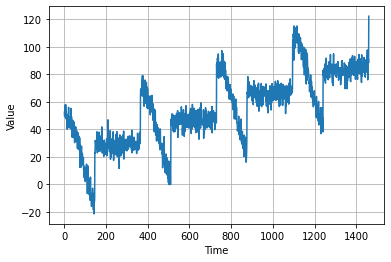

In [32]:
plot_series(time, series)

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset=dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset=dataset.shuffle(buffer_size=shuffle_buffer)
  dataset=dataset.batch(batch_size).prefetch(1)

  return dataset

In [33]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [34]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

dataset=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [62]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

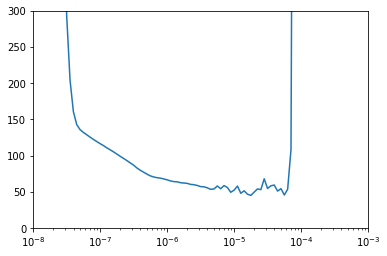

In [63]:
lrs=1e-8 * 10**(np.arange(100)/20)
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [64]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

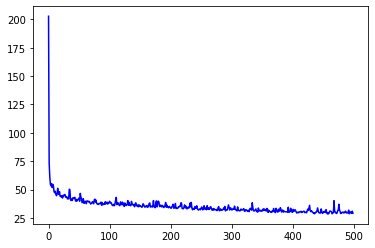

In [65]:
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

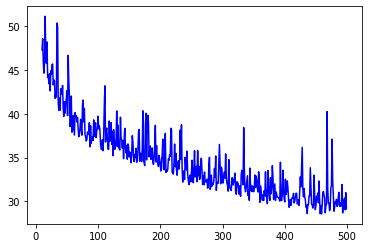

In [66]:
loss=history.history['loss']
epochs=range(10,len(loss))
loss=loss[10:]
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [68]:
forecast=[]

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))

forecast=forecast[split_time-window_size:]

results=np.array(forecast)[:,0,0]

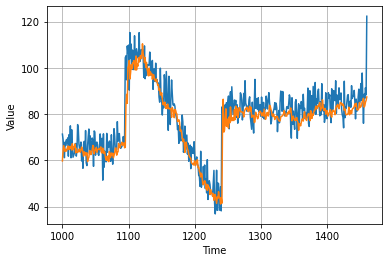

In [69]:
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [70]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.112908